In [1]:
##### Es necesario montar el drive para poder cargar el dataset
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!git clone https://github.com/Rmejiaz/CrowdLayer

Cloning into 'CrowdLayer'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 71 (delta 7), reused 11 (delta 4), pack-reused 54
Unpacking objects: 100% (71/71), 286.12 KiB | 1.23 MiB/s, done.


In [3]:
cd CrowdLayer/

/kaggle/working/CrowdLayer


# Import required libraries

In [4]:
import numpy as np
import pandas as pd
import os 
import csv
import tensorflow as tf
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Rescaling
import keras

# packages for learning from crowds
from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization
 

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

# prevent tensorflow from allocating the entire GPU memory at once
# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# seed_value= 43
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

# Data configuration

In [5]:
NUM_RUNS = 30
DATA_PATH_Tr = '/kaggle/input/labelme/LabelMe/train'
DATA_PATH_Te = '/kaggle/input/labelme/LabelMe/test'
DATA_PATH_Val = '/kaggle/input/labelme/LabelMe/valid'
N_CLASSES = 8
BATCH_SIZE = 128
N_EPOCHS = 100
N_ANNOT = 59



# Cargar datos con las etiquetas verdaderas.

In [6]:
Data_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory = DATA_PATH_Tr,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(128, 128),
    shuffle=True,
    validation_split=None,
)

Data_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory = DATA_PATH_Te,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(128, 128),
    shuffle=True,
    validation_split=None,
)

Data_valid = tf.keras.preprocessing.image_dataset_from_directory(
    directory = DATA_PATH_Val,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(128, 128),
    shuffle=True,
    validation_split=None,
)

Found 1000 files belonging to 8 classes.


2022-12-21 04:59:15.476487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 04:59:15.591801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 04:59:15.592566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 04:59:15.595349: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 1188 files belonging to 8 classes.
Found 500 files belonging to 8 classes.


# Define the base deep learning model


In [7]:
def create_model():
    
    #l1 = 1e-3
    base_model = Sequential()
    base_model.add(Rescaling(1./255,  input_shape=(128, 128, 3)))
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3))) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
   
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3))) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
    

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3))) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3))) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))


    base_model.add(Flatten()) 
    base_model.add(BatchNormalization())
    base_model.add(Dense(256)) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Dropout(0.75))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation('softmax'))

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm = 1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return base_model

In [8]:
class_names = Data_valid.class_names
print(class_names)

['coast', 'forest', 'highway', 'insidecity', 'mountain', 'opencountry', 'street', 'tallbuilding']


2022-12-21 04:59:19.598272: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


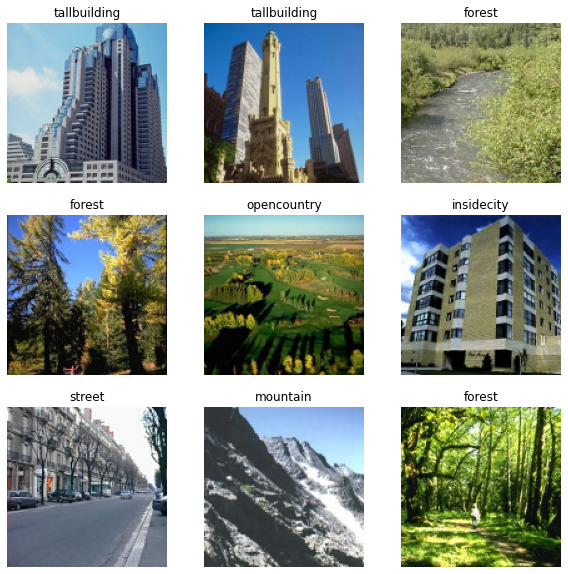

In [9]:
import matplotlib.pyplot as plt

 

plt.figure(figsize=(10, 10))
for images, labels in Data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #print(images[0,1,:, 2])
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/70


2022-12-21 04:59:28.317106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 - 13s - loss: 2.9305 - accuracy: 0.3350 - val_loss: 53.4034 - val_accuracy: 0.1180
Epoch 2/70
8/8 - 2s - loss: 1.5718 - accuracy: 0.5370 - val_loss: 61.8693 - val_accuracy: 0.1500
Epoch 3/70
8/8 - 2s - loss: 1.2682 - accuracy: 0.5840 - val_loss: 35.0415 - val_accuracy: 0.1620
Epoch 4/70
8/8 - 2s - loss: 1.1005 - accuracy: 0.6390 - val_loss: 17.2311 - val_accuracy: 0.1840
Epoch 5/70
8/8 - 2s - loss: 0.9097 - accuracy: 0.6850 - val_loss: 5.6702 - val_accuracy: 0.2960
Epoch 6/70
8/8 - 2s - loss: 0.7698 - accuracy: 0.7320 - val_loss: 2.2869 - val_accuracy: 0.4640
Epoch 7/70
8/8 - 2s - loss: 0.7343 - accuracy: 0.7570 - val_loss: 2.5161 - val_accuracy: 0.4580
Epoch 8/70
8/8 - 2s - loss: 0.6386 - accuracy: 0.7950 - val_loss: 4.0243 - val_accuracy: 0.2940
Epoch 9/70
8/8 - 2s - loss: 0.5687 - accuracy: 0.7920 - val_loss: 2.5342 - val_accuracy: 0.4080
Epoch 10/70
8/8 - 2s - loss: 0.5316 - accuracy: 0.8140 - val_loss: 1.8596 - val_accuracy: 0.5480
Epoch 11/70
8/8 - 2s - loss: 0.4589 - accurac

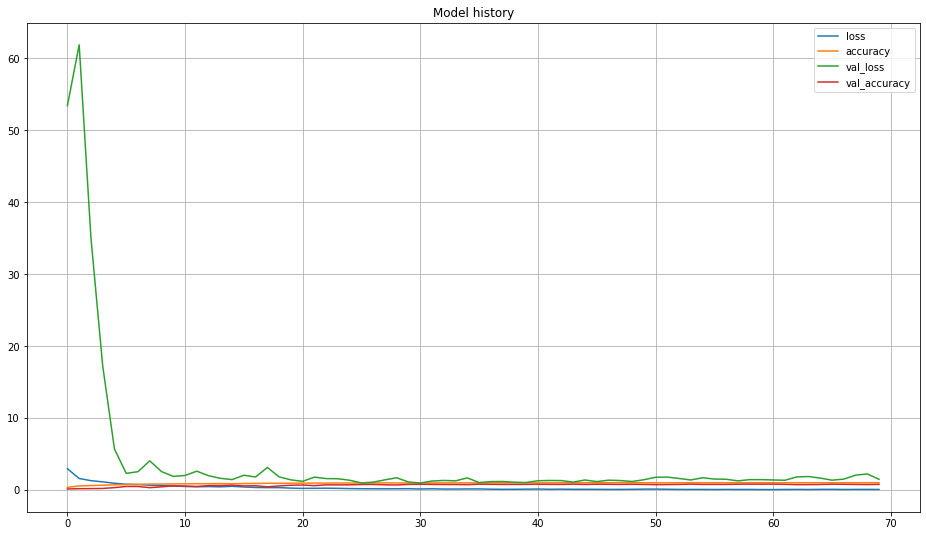

Epoch 1/70
8/8 - 4s - loss: 2.8849 - accuracy: 0.3290 - val_loss: 35.0965 - val_accuracy: 0.1300
Epoch 2/70
8/8 - 2s - loss: 1.7675 - accuracy: 0.4780 - val_loss: 46.9813 - val_accuracy: 0.1480
Epoch 3/70
8/8 - 2s - loss: 1.4708 - accuracy: 0.5480 - val_loss: 28.1170 - val_accuracy: 0.1560
Epoch 4/70
8/8 - 2s - loss: 1.2063 - accuracy: 0.6080 - val_loss: 13.4123 - val_accuracy: 0.1860
Epoch 5/70
8/8 - 2s - loss: 1.0406 - accuracy: 0.6620 - val_loss: 9.0338 - val_accuracy: 0.2220
Epoch 6/70
8/8 - 2s - loss: 0.9532 - accuracy: 0.6540 - val_loss: 6.8817 - val_accuracy: 0.2720
Epoch 7/70
8/8 - 2s - loss: 0.7617 - accuracy: 0.7390 - val_loss: 3.5070 - val_accuracy: 0.3440
Epoch 8/70
8/8 - 2s - loss: 0.7594 - accuracy: 0.7350 - val_loss: 4.8655 - val_accuracy: 0.3240
Epoch 9/70
8/8 - 3s - loss: 0.6960 - accuracy: 0.7550 - val_loss: 2.9443 - val_accuracy: 0.3980
Epoch 10/70
8/8 - 2s - loss: 0.5862 - accuracy: 0.8030 - val_loss: 3.4374 - val_accuracy: 0.3740
Epoch 11/70
8/8 - 2s - loss: 0.5705

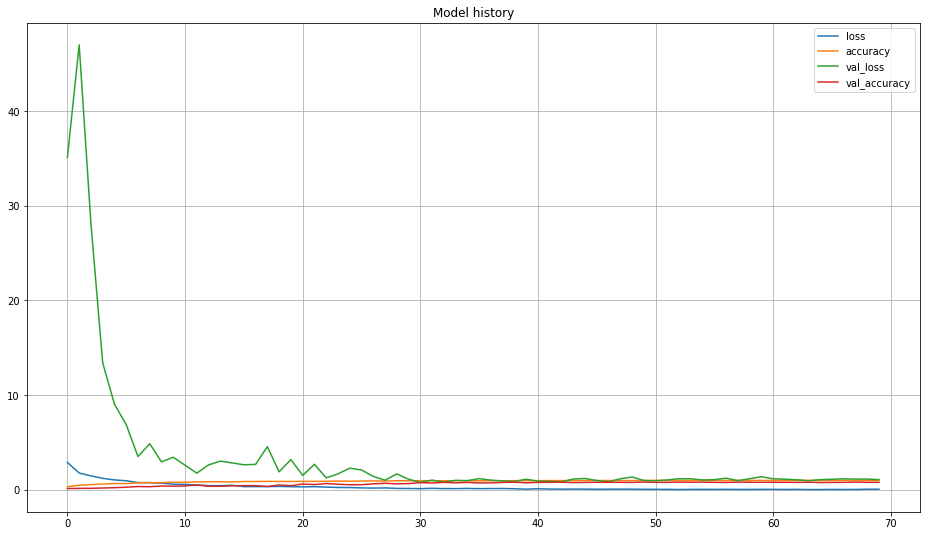

Epoch 1/70
8/8 - 4s - loss: 3.1735 - accuracy: 0.3070 - val_loss: 44.2910 - val_accuracy: 0.1600
Epoch 2/70
8/8 - 2s - loss: 1.8253 - accuracy: 0.4780 - val_loss: 24.8164 - val_accuracy: 0.1680
Epoch 3/70
8/8 - 2s - loss: 1.1322 - accuracy: 0.6230 - val_loss: 27.5684 - val_accuracy: 0.1600
Epoch 4/70
8/8 - 2s - loss: 0.9944 - accuracy: 0.6670 - val_loss: 15.8780 - val_accuracy: 0.1760
Epoch 5/70
8/8 - 2s - loss: 0.8785 - accuracy: 0.7140 - val_loss: 11.7839 - val_accuracy: 0.2080
Epoch 6/70
8/8 - 2s - loss: 0.7457 - accuracy: 0.7520 - val_loss: 8.9601 - val_accuracy: 0.2020
Epoch 7/70
8/8 - 2s - loss: 0.7308 - accuracy: 0.7530 - val_loss: 9.0245 - val_accuracy: 0.2140
Epoch 8/70
8/8 - 2s - loss: 0.6709 - accuracy: 0.7730 - val_loss: 6.6709 - val_accuracy: 0.2660
Epoch 9/70
8/8 - 2s - loss: 0.5861 - accuracy: 0.8110 - val_loss: 5.6404 - val_accuracy: 0.3100
Epoch 10/70
8/8 - 2s - loss: 0.4954 - accuracy: 0.8270 - val_loss: 7.3583 - val_accuracy: 0.3000
Epoch 11/70
8/8 - 2s - loss: 0.417

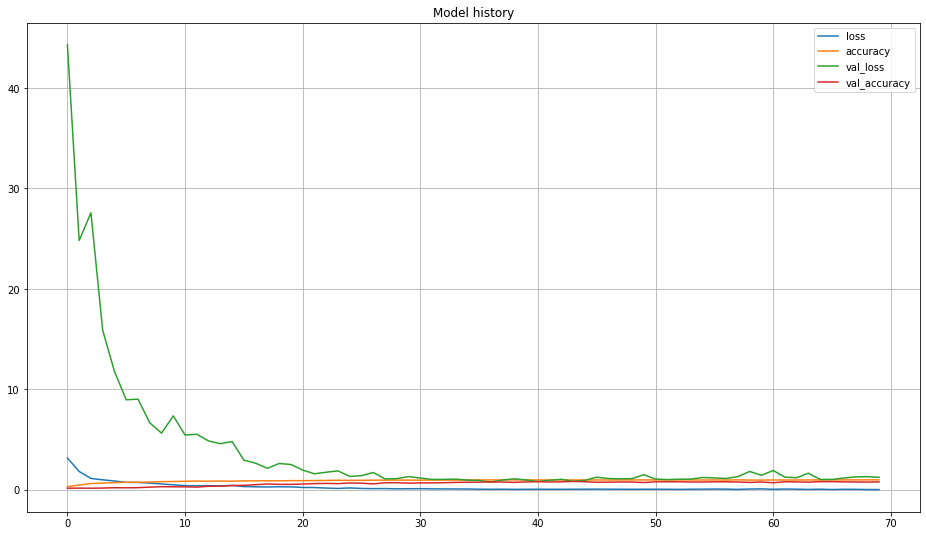

Epoch 1/70
8/8 - 4s - loss: 3.2964 - accuracy: 0.2860 - val_loss: 19.9083 - val_accuracy: 0.1480
Epoch 2/70
8/8 - 2s - loss: 2.0179 - accuracy: 0.3880 - val_loss: 21.4546 - val_accuracy: 0.1320
Epoch 3/70
8/8 - 2s - loss: 1.3910 - accuracy: 0.5360 - val_loss: 17.2346 - val_accuracy: 0.1440
Epoch 4/70
8/8 - 2s - loss: 1.1380 - accuracy: 0.6000 - val_loss: 14.0854 - val_accuracy: 0.1200
Epoch 5/70
8/8 - 2s - loss: 0.9298 - accuracy: 0.6550 - val_loss: 6.2496 - val_accuracy: 0.2340
Epoch 6/70
8/8 - 2s - loss: 0.8346 - accuracy: 0.7140 - val_loss: 4.8205 - val_accuracy: 0.2280
Epoch 7/70
8/8 - 2s - loss: 0.7516 - accuracy: 0.7330 - val_loss: 3.3919 - val_accuracy: 0.3400
Epoch 8/70
8/8 - 2s - loss: 0.6940 - accuracy: 0.7620 - val_loss: 3.0174 - val_accuracy: 0.3760
Epoch 9/70
8/8 - 2s - loss: 0.6296 - accuracy: 0.7970 - val_loss: 2.7304 - val_accuracy: 0.4100
Epoch 10/70
8/8 - 2s - loss: 0.6271 - accuracy: 0.7850 - val_loss: 3.3689 - val_accuracy: 0.3700
Epoch 11/70
8/8 - 2s - loss: 0.5819

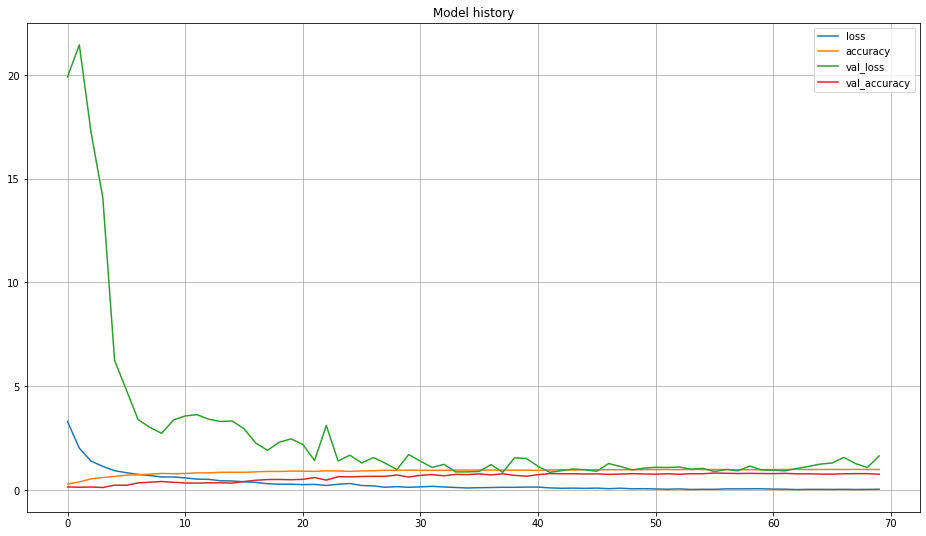

Epoch 1/70
8/8 - 4s - loss: 3.0994 - accuracy: 0.3160 - val_loss: 14.3749 - val_accuracy: 0.1380
Epoch 2/70
8/8 - 2s - loss: 1.7263 - accuracy: 0.4810 - val_loss: 11.5161 - val_accuracy: 0.2080
Epoch 3/70
8/8 - 2s - loss: 1.3322 - accuracy: 0.5860 - val_loss: 12.9370 - val_accuracy: 0.1680
Epoch 4/70
8/8 - 2s - loss: 1.1643 - accuracy: 0.6110 - val_loss: 6.0972 - val_accuracy: 0.2380
Epoch 5/70
8/8 - 2s - loss: 0.9259 - accuracy: 0.6860 - val_loss: 3.8621 - val_accuracy: 0.3080
Epoch 6/70
8/8 - 2s - loss: 0.7839 - accuracy: 0.7310 - val_loss: 4.5674 - val_accuracy: 0.2600
Epoch 7/70
8/8 - 2s - loss: 0.6849 - accuracy: 0.7670 - val_loss: 4.0744 - val_accuracy: 0.2220
Epoch 8/70
8/8 - 2s - loss: 0.6124 - accuracy: 0.7950 - val_loss: 5.7178 - val_accuracy: 0.2240
Epoch 9/70
8/8 - 2s - loss: 0.5585 - accuracy: 0.8130 - val_loss: 5.0976 - val_accuracy: 0.2340
Epoch 10/70
8/8 - 2s - loss: 0.5368 - accuracy: 0.8310 - val_loss: 3.8603 - val_accuracy: 0.2480
Epoch 11/70
8/8 - 2s - loss: 0.4925 

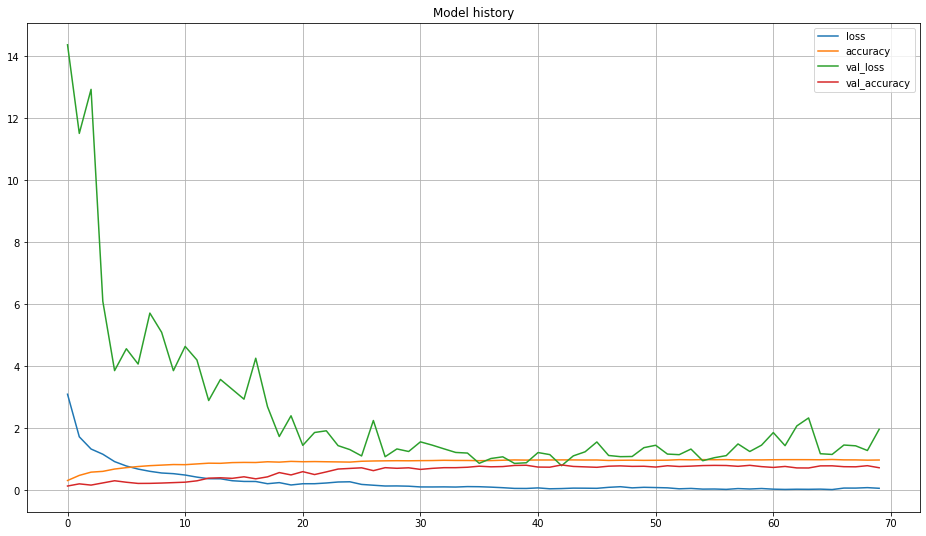

Epoch 1/70
8/8 - 4s - loss: 3.0541 - accuracy: 0.3260 - val_loss: 69.9020 - val_accuracy: 0.0980
Epoch 2/70
8/8 - 2s - loss: 1.7354 - accuracy: 0.5070 - val_loss: 99.7092 - val_accuracy: 0.1540
Epoch 3/70
8/8 - 2s - loss: 1.3132 - accuracy: 0.5890 - val_loss: 50.6785 - val_accuracy: 0.1300
Epoch 4/70
8/8 - 2s - loss: 1.0099 - accuracy: 0.6590 - val_loss: 19.6784 - val_accuracy: 0.1700
Epoch 5/70
8/8 - 2s - loss: 0.9112 - accuracy: 0.6930 - val_loss: 8.4673 - val_accuracy: 0.3160
Epoch 6/70
8/8 - 2s - loss: 0.7930 - accuracy: 0.7330 - val_loss: 3.7844 - val_accuracy: 0.3680
Epoch 7/70
8/8 - 2s - loss: 0.6908 - accuracy: 0.7520 - val_loss: 6.1384 - val_accuracy: 0.3180
Epoch 8/70
8/8 - 2s - loss: 0.6591 - accuracy: 0.7710 - val_loss: 5.5082 - val_accuracy: 0.2640
Epoch 9/70
8/8 - 2s - loss: 0.6594 - accuracy: 0.7640 - val_loss: 4.1128 - val_accuracy: 0.3480
Epoch 10/70
8/8 - 2s - loss: 0.6424 - accuracy: 0.7660 - val_loss: 2.7224 - val_accuracy: 0.4720
Epoch 11/70
8/8 - 2s - loss: 0.5636

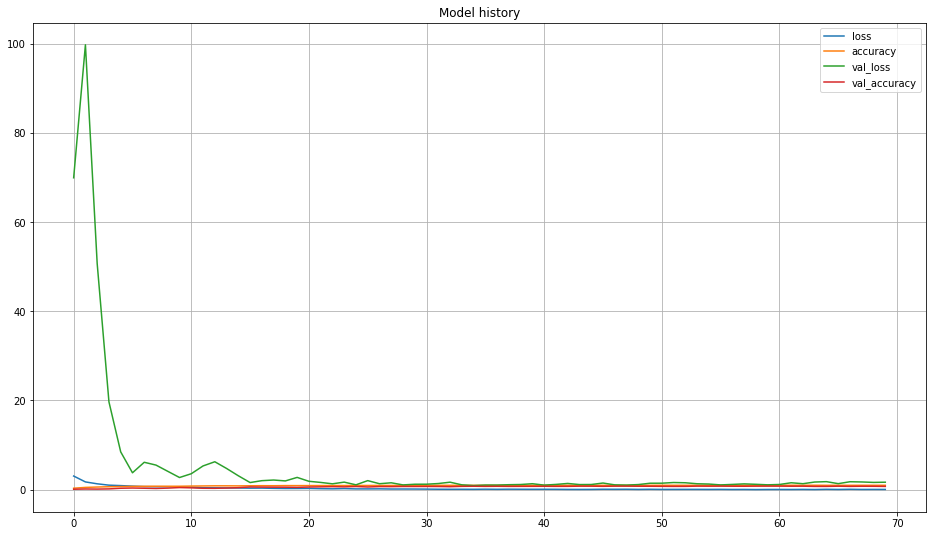

Epoch 1/70
8/8 - 4s - loss: 3.0677 - accuracy: 0.3600 - val_loss: 38.3381 - val_accuracy: 0.1320
Epoch 2/70
8/8 - 2s - loss: 1.8061 - accuracy: 0.4680 - val_loss: 36.1954 - val_accuracy: 0.1220
Epoch 3/70
8/8 - 2s - loss: 1.2639 - accuracy: 0.5990 - val_loss: 28.5620 - val_accuracy: 0.1220
Epoch 4/70
8/8 - 2s - loss: 1.0089 - accuracy: 0.6560 - val_loss: 13.2195 - val_accuracy: 0.1920
Epoch 5/70
8/8 - 2s - loss: 0.8646 - accuracy: 0.7130 - val_loss: 11.7196 - val_accuracy: 0.2180
Epoch 6/70
8/8 - 2s - loss: 0.7208 - accuracy: 0.7570 - val_loss: 9.8137 - val_accuracy: 0.1500
Epoch 7/70
8/8 - 2s - loss: 0.7168 - accuracy: 0.7660 - val_loss: 8.8038 - val_accuracy: 0.1920
Epoch 8/70
8/8 - 2s - loss: 0.6176 - accuracy: 0.7820 - val_loss: 2.2229 - val_accuracy: 0.5060
Epoch 9/70
8/8 - 2s - loss: 0.5452 - accuracy: 0.8150 - val_loss: 2.9602 - val_accuracy: 0.3880
Epoch 10/70
8/8 - 2s - loss: 0.5179 - accuracy: 0.8250 - val_loss: 2.7088 - val_accuracy: 0.3960
Epoch 11/70
8/8 - 2s - loss: 0.486

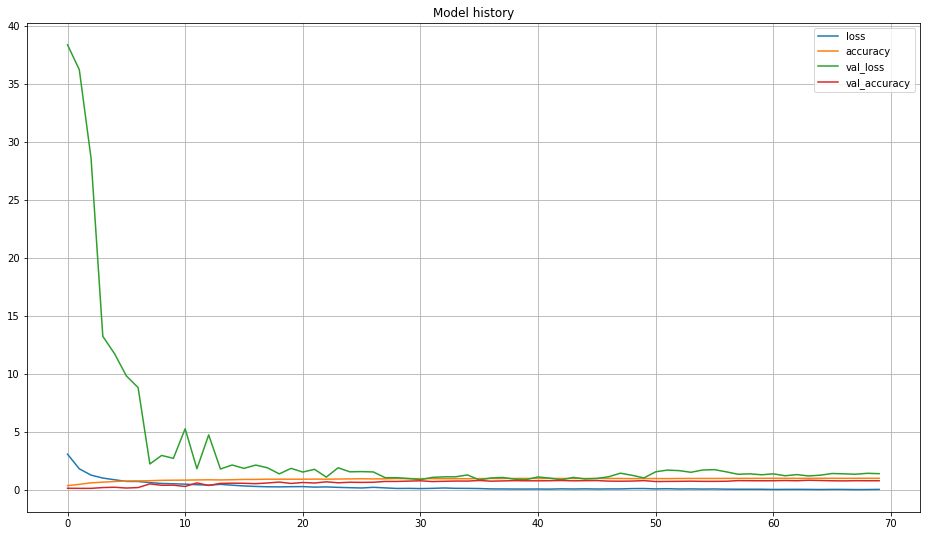

Epoch 1/70
8/8 - 4s - loss: 3.0655 - accuracy: 0.3100 - val_loss: 92.2540 - val_accuracy: 0.1480
Epoch 2/70
8/8 - 2s - loss: 1.7846 - accuracy: 0.4950 - val_loss: 69.6644 - val_accuracy: 0.1420
Epoch 3/70
8/8 - 2s - loss: 1.3023 - accuracy: 0.5680 - val_loss: 41.8397 - val_accuracy: 0.1300
Epoch 4/70
8/8 - 2s - loss: 1.0714 - accuracy: 0.6370 - val_loss: 16.8279 - val_accuracy: 0.1680
Epoch 5/70
8/8 - 2s - loss: 0.8835 - accuracy: 0.7080 - val_loss: 13.8353 - val_accuracy: 0.1820
Epoch 6/70
8/8 - 2s - loss: 0.8323 - accuracy: 0.7150 - val_loss: 7.4195 - val_accuracy: 0.2520
Epoch 7/70
8/8 - 2s - loss: 0.7089 - accuracy: 0.7440 - val_loss: 3.7411 - val_accuracy: 0.4360
Epoch 8/70
8/8 - 2s - loss: 0.6629 - accuracy: 0.7720 - val_loss: 4.4369 - val_accuracy: 0.3020
Epoch 9/70
8/8 - 2s - loss: 0.6071 - accuracy: 0.7980 - val_loss: 4.5830 - val_accuracy: 0.2660
Epoch 10/70
8/8 - 2s - loss: 0.6098 - accuracy: 0.7900 - val_loss: 3.7792 - val_accuracy: 0.2720
Epoch 11/70
8/8 - 2s - loss: 0.508

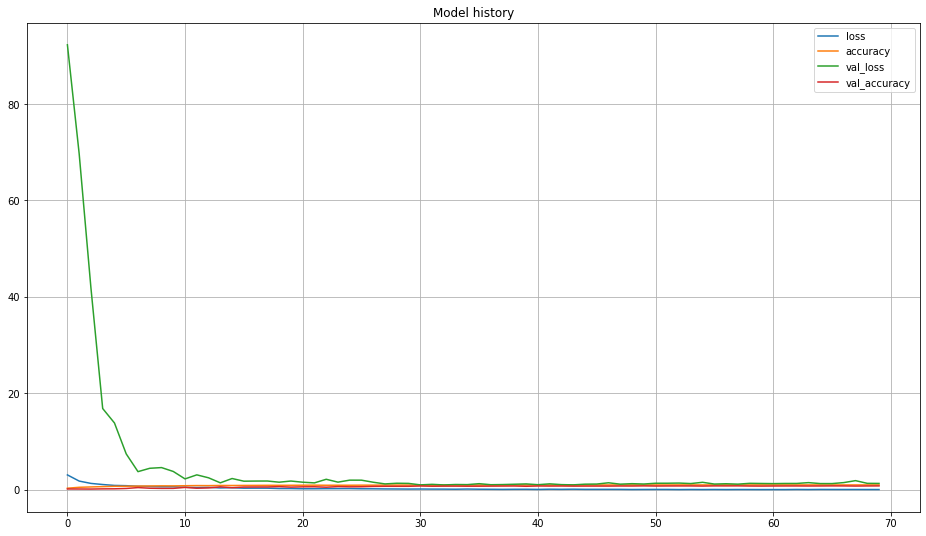

Epoch 1/70
8/8 - 4s - loss: 3.0358 - accuracy: 0.3280 - val_loss: 34.2064 - val_accuracy: 0.1020
Epoch 2/70
8/8 - 2s - loss: 1.5829 - accuracy: 0.5330 - val_loss: 55.2188 - val_accuracy: 0.1400
Epoch 3/70
8/8 - 2s - loss: 1.1876 - accuracy: 0.6080 - val_loss: 12.9809 - val_accuracy: 0.2720
Epoch 4/70
8/8 - 2s - loss: 0.9650 - accuracy: 0.6840 - val_loss: 15.1370 - val_accuracy: 0.2060
Epoch 5/70
8/8 - 2s - loss: 0.8349 - accuracy: 0.7290 - val_loss: 8.6168 - val_accuracy: 0.2200
Epoch 6/70
8/8 - 2s - loss: 0.7580 - accuracy: 0.7530 - val_loss: 15.9828 - val_accuracy: 0.1580
Epoch 7/70
8/8 - 2s - loss: 0.6529 - accuracy: 0.7840 - val_loss: 4.6696 - val_accuracy: 0.2660
Epoch 8/70
8/8 - 2s - loss: 0.5836 - accuracy: 0.7950 - val_loss: 4.9750 - val_accuracy: 0.2480
Epoch 9/70
8/8 - 2s - loss: 0.5520 - accuracy: 0.8220 - val_loss: 6.2708 - val_accuracy: 0.2640
Epoch 10/70
8/8 - 2s - loss: 0.5194 - accuracy: 0.8420 - val_loss: 4.3075 - val_accuracy: 0.2960
Epoch 11/70
8/8 - 2s - loss: 0.432

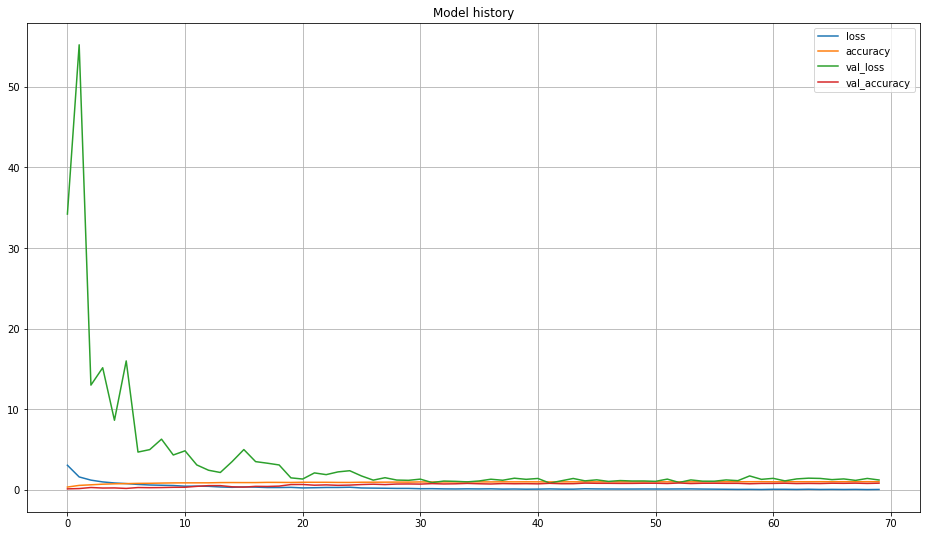

Epoch 1/70
8/8 - 4s - loss: 3.2574 - accuracy: 0.3020 - val_loss: 61.2195 - val_accuracy: 0.1380
Epoch 2/70
8/8 - 2s - loss: 1.8942 - accuracy: 0.4290 - val_loss: 24.9560 - val_accuracy: 0.1520
Epoch 3/70
8/8 - 2s - loss: 1.4574 - accuracy: 0.5290 - val_loss: 23.6217 - val_accuracy: 0.1640
Epoch 4/70
8/8 - 2s - loss: 1.2492 - accuracy: 0.5840 - val_loss: 23.7352 - val_accuracy: 0.1800
Epoch 5/70
8/8 - 2s - loss: 1.0866 - accuracy: 0.6550 - val_loss: 10.2036 - val_accuracy: 0.1740
Epoch 6/70
8/8 - 2s - loss: 0.8156 - accuracy: 0.7150 - val_loss: 6.1812 - val_accuracy: 0.2460
Epoch 7/70
8/8 - 2s - loss: 0.7235 - accuracy: 0.7540 - val_loss: 9.9857 - val_accuracy: 0.1840
Epoch 8/70
8/8 - 2s - loss: 0.6815 - accuracy: 0.7560 - val_loss: 3.6216 - val_accuracy: 0.3560
Epoch 9/70
8/8 - 2s - loss: 0.6450 - accuracy: 0.7760 - val_loss: 2.9106 - val_accuracy: 0.3960
Epoch 10/70
8/8 - 2s - loss: 0.5756 - accuracy: 0.7990 - val_loss: 5.6123 - val_accuracy: 0.2760
Epoch 11/70
8/8 - 2s - loss: 0.579

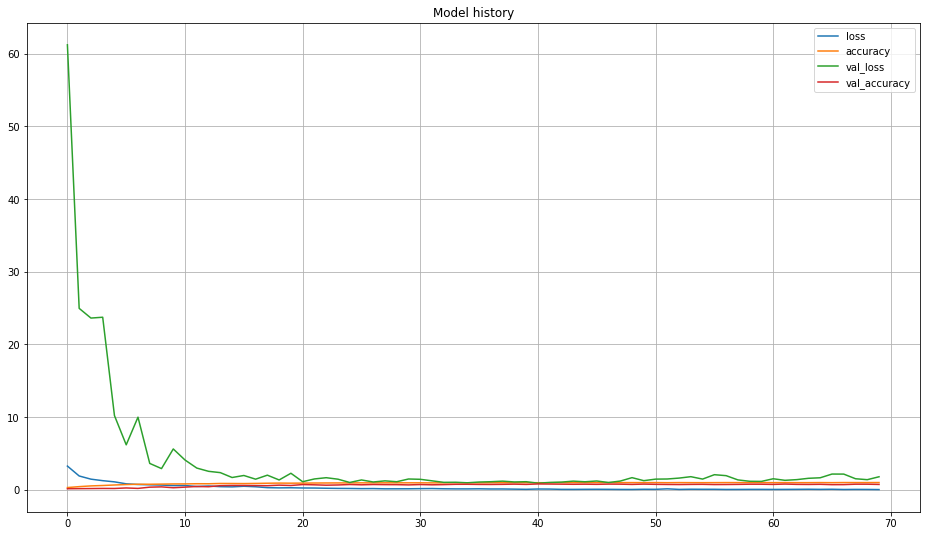

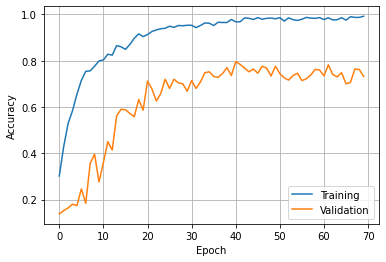

In [11]:
NUM_RUNS = 10
N_EPOCHS = 70


    # Create the results directory
# if  not 'results' in os.listdir():
#     os.mkdir('/kaggle/working/results')
AUC = np.zeros(NUM_RUNS)
val_acc_goldst = np.zeros(NUM_RUNS)

for i in range(NUM_RUNS):
    model = create_model()
    model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(lr=1e-2, clipnorm = 1.0))
    trainHistory = model.fit(Data_train, validation_data=Data_valid, epochs=N_EPOCHS, verbose=2)  #callbacks=callbacks, 
    (loss, accuracy) = model.evaluate(Data_test)
    val_acc_goldst[i] = accuracy


    # Create the history figure
    plt.figure(figsize=(16,9))
    for l in  trainHistory.history:
        plt.plot( trainHistory.history[l],label=l)
    plt.title('Model history')
    plt.legend()
    plt.grid()

   
    
     #AUC

    val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)
    for x_batch_val, y_batch_val in Data_test:
        val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
        val_AUC_metric.update_state(y_batch_val, val_logits.numpy().argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC

     # Save the figure
    i = 0
    flag = True
    while(flag==True):
        if (f'history{i}' in os.listdir('/kaggle/working')):
            i+=1
        else:
            plt.savefig(f'/kaggle/working/history{i}')
            flag=False

    plt.show()
df_gold = pd.DataFrame(val_acc_goldst)
df_gold.to_csv('/kaggle/working/labelme_GOLD.csv',index=False) # save to notebook output
  

plt.plot(trainHistory.history['accuracy'])
plt.plot(trainHistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [12]:
val_acc_goldst

array([0.77188551, 0.79377103, 0.77525252, 0.76346803, 0.75505048,
       0.75168347, 0.78872055, 0.77861953, 0.81734008, 0.78198653])

In [13]:
 
AUC
     

array([0.91587669, 0.88080919, 0.90861267, 0.91816956, 0.8284778 ,
       0.88932568, 0.88928711, 0.89258182, 0.92687863, 0.89743733])

In [14]:

print('Average Accuracy: ', np.round(val_acc_goldst.mean(),4)*100) 
print('Average std: ',np.round(np.std(val_acc_goldst),4)*100)

Average Accuracy:  77.78
Average std:  1.8399999999999999


In [15]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

     

Average Accuracy:  89.47
Average std:  2.62


# Cargar datos con múltiples anotadores

In [16]:
# with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/filenames_train.txt', 'r') as file:
#     reader = csv.reader(file)
#     Names = []
#     for row in reader:
#         Names.append(row[0])

# with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/labels_train.txt', 'r') as file:
#     reader = csv.reader(file)
#     y_ = []
#     for row in reader:
#         y_.append(row[0])


# Data = pd.read_csv('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/answers.txt', sep=" ", header=None)
# A_ = Data.loc[:,Data.sum() > -990]
# Y_ = A_.values

# # with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/prepared/answers.npy', mode = 'rb') as file:
# #     Y_ = np.load(file)

# # with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/prepared/labels_train.npy', mode = 'rb') as file:
# #     y_ = np.load(file)

# A = os.walk(DATA_PATH_Tr)
# Y = []
# y = []
# for r,d,files in A:
#   d.sort()
#   if len(files) != 0:
#     print(files)
#     for fil_ in sorted(files):
#       Y.append(Y_[Names.index(fil_),:])
#       y.append(int(y_[Names.index(fil_)]))

In [17]:
# Data_train_MA = tf.keras.preprocessing.image_dataset_from_directory(
#     directory = DATA_PATH_Tr,
#     labels=Y,
#     label_mode="int",
#     color_mode="rgb",
#     batch_size=BATCH_SIZE,
#     image_size=(128, 128),
#     shuffle=True,
#     validation_split=None,
# )

In [18]:
# with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/labels_test.txt', 'r') as file:
#     reader = csv.reader(file)
#     y_te = []
#     for row in reader:
#         y_te.append(row[0])

# with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/filenames_test.txt', 'r') as file:
#     reader = csv.reader(file)
#     Names = []
#     for row in reader:
#         Names.append(row[0])

# A = os.walk(DATA_PATH_Te)
# y_test = []
# for r,d,files in A:
#   d.sort()
#   if len(files) != 0:
#     print(files)
#     for fil_ in sorted(files):
#       y_test.append(int(y_te[Names.index(fil_)]))

In [19]:
# Data_test_MA = tf.keras.preprocessing.image_dataset_from_directory(
#     directory = DATA_PATH_Te,
#     labels=y_test,
#     label_mode="int",
#     color_mode="rgb",
#     batch_size=BATCH_SIZE,
#     image_size=(128, 128),
#     shuffle=True,
#     validation_split=None,
# )

# Auxiliary function for evaluating the models

In [20]:
# def eval_model(model, test_data, test_labels):
#     # testset accuracy
#     preds_test = model.predict(test_data)
#     preds_test_num = np.argmax(preds_test, axis=1)
#     accuracy_test = 1.0*np.sum(preds_test_num == test_labels) / len(test_labels)

#     return accuracy_test

# Proposed Model

In [21]:
# import sys
# sys.path.append("/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Models")
# from Multiple_Annotators_C_v1 import MultipleAnnotators_Classification

In [22]:
# MA = MultipleAnnotators_Classification(N_CLASSES, N_ANNOT)
# def create_model():
#   base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(128, 128, 3),
#   )
#   base_model.trainable = False
#   inputs = keras.Input(shape=(128, 128, 3))
#   x = base_model(inputs)
#   x = keras.layers.Flatten()(x)
#   x = keras.layers.Dropout(0.5)(x)
#   x = keras.layers.Dense(256)(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.Dropout(0.5)(x)
#   output = MA.CrowdLayer(x)
#   model = keras.Model(inputs=inputs,outputs=output)
#   return model

In [23]:

# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(N_CLASSES, N_ANNOT)
#   model = create_model()
#   model = MA.fit(model, Data_train_MA, N_EPOCHS)
#   val_acc[i] = MA.eval_model(Data_test_MA)
#   print("Validation acc: %.4f" % (float(val_acc[i]),))

In [24]:
# print(val_acc)

In [25]:
# r1 = np.mean(val_acc)
# print("\nMean: ", r1)
  
# r2 = np.std(val_acc)
# print("\nstd: ", r2)
  
# r3 = np.var(val_acc)
# print("\nvariance: ", r3)

In [26]:

# plt.plot(val_acc, range(NUM_RUNS))
# #plt.plot(h.history['val_accuracy'])
# plt.title('Model MA accuracy',fontsize=14, fontweight='bold')
# plt.ylabel('Accuracy',fontsize=14, fontweight='bold')
# #plt.xlabel('Epoch',fontsize=14, fontweight='bold')
# plt.legend(['Test'], loc='upper left')
# #plt.ylim(0.7, 1.0)
# plt.grid()
# plt.show()
